In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import lightgbm as lgb
import re
import xgboost as xgb


SEED = 42

In [2]:
df_listing = pd.read_csv("C:/Users/Sevester Retseves/Desktop/SEVESTER/Data Analytics/Python/Capstone/Berlin/listings_summary.csv")


In [3]:
#rows and columns
print("The dataset has {} rows and {} columns.".format(*df_listing.shape))
#duplicate
print("It contains {} duplicates.".format(df_listing.duplicated().sum()))


The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


In [4]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   listing_url                       22552 non-null  object 
 2   scrape_id                         22552 non-null  int64  
 3   last_scraped                      22552 non-null  object 
 4   name                              22493 non-null  object 
 5   summary                           21589 non-null  object 
 6   space                             14020 non-null  object 
 7   description                       22349 non-null  object 
 8   experiences_offered               22552 non-null  object 
 9   neighborhood_overview             11540 non-null  object 
 10  notes                             7215 non-null   object 
 11  transit                           13036 non-null  object 
 12  acce

In [5]:
df_listing.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


In [6]:
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

# Processing Data

In [7]:
#Choosing which columns to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_listing[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 22552 rows and 23 columns - after dropping irrelevant columns.


In [8]:
#how many room type
df_raw.room_type.value_counts(normalize=True)

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

In [9]:
#how many property type
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Houseboat                 0.000488
Camper/RV                 0.000488
Villa                     0.000443
Aparthotel                0.000310
Pension (South Korea)     0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Castle                    0.000089
Casa particular (Cuba)    0.000089
Train                     0.000089
Barn                      0.000044
In-law              

In [10]:
#missing value
df_raw.isna().sum()

space                            8532
description                       203
host_has_profile_pic               26
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     22106
price                               0
cleaning_fee                     7146
security_deposit                 9361
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [11]:
#replace cleaning_fee's null value to $0.00
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

In [12]:
#replcae security_deposit's null value to $0.00
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [13]:
#remove $ and change to float type
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [14]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

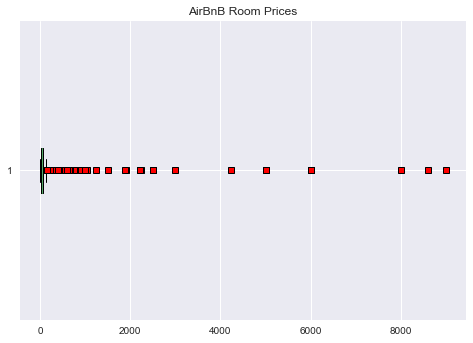

In [15]:
red_square = dict(markerfacecolor='r', marker='s')
fig5, ax5 = plt.subplots()
ax5.set_title('Horizontal Boxes')
ax5.boxplot(df_raw['price'], vert=False, flierprops=red_square)
ax5.set_title('AirBnB Room Prices')
plt.show()

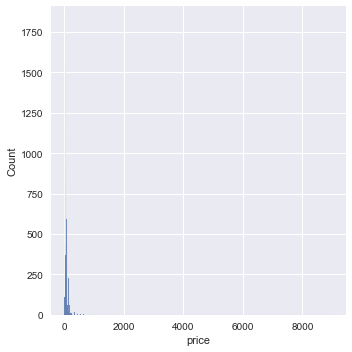

In [16]:
sns.displot(df_raw['price'])

In [17]:
#delete price > $500 and price = $0
df_raw.drop(df_raw[ (df_raw.price > 500) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [18]:
df_raw['price'].describe()

count    22470.000000
mean        58.117980
std         44.687913
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        500.000000
Name: price, dtype: float64

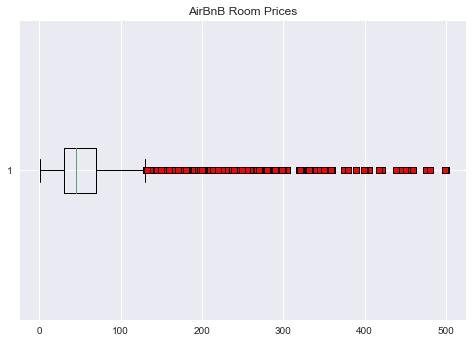

In [19]:
red_square = dict(markerfacecolor='r', marker='s')
fig5, ax5 = plt.subplots()
ax5.set_title('Horizontal Boxes')
ax5.boxplot(df_raw['price'], vert=False, flierprops=red_square)
ax5.set_title('AirBnB Room Prices')
plt.show()

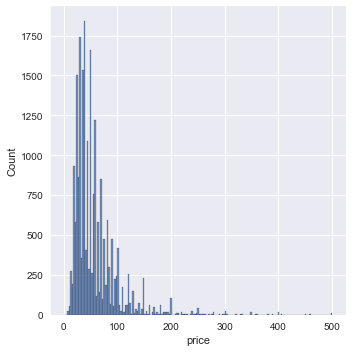

In [20]:
sns.displot(df_raw['price'])

In [21]:
#delete columns with too many missing values
df_raw.drop(columns = ['space', 'square_feet'], inplace= True)

In [22]:
df_raw.isna().sum()

description                     202
host_has_profile_pic             25
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                        32
bedrooms                         18
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [23]:
#delete missing values in bathrooms&bedrooms
df_raw.dropna(subset = ['bathrooms', 'bedrooms'], inplace = True)

In [24]:
df_raw.isna().sum()

description                     202
host_has_profile_pic             25
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [25]:
#checking what kind of data is in host_has_profile_pic
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [26]:
#replacing nan with f
df_raw.host_has_profile_pic.fillna(value= 'f', inplace = True)

In [27]:
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [28]:
df_raw.isna().sum()

description                     202
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [29]:
#data after processed
print("The dataset has {} rows and {} columns".format(*df_raw.shape))

The dataset has 22420 rows and 21 columns


# Feature Engineering

In [30]:
from geopy.distance import great_circle

In [31]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    airbnb = (lat, lon)
    return great_circle(berlin_centre, airbnb).km

In [32]:
df_raw['distance_in_km'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [33]:
df_raw.head(3)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance_in_km
id,,,,,,,,,,,,,,,,,,,,,
2015,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,...,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,3.533182
2695,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,...,17.0,0.0,0.0,0.0,1,2,f,f,flexible,5.085573
3176,This beautiful first floor apartment is situa...,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,...,90.0,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period,3.695677


In [34]:
#extract numbers from description
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

#change datatype of size into float
df_raw['size'] = df_raw['size'].astype(float)

In [35]:
df_raw[['description', 'size']].head(3)

,description,size
id,,
2015,Great location! 30 of 75 sq meters. This wood...,75.0
2695,In the summertime we are spending most of our ...,25.0
3176,This beautiful first floor apartment is situa...,68.0


In [36]:
df_raw.isna().sum()

description                       202
host_has_profile_pic                0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
distance_in_km                      0
size                            11735
dtype: int64

In [37]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22420 entries, 2015 to 29867352
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   description                   22218 non-null  object 
 1   host_has_profile_pic          22420 non-null  object 
 2   neighbourhood_group_cleansed  22420 non-null  object 
 3   latitude                      22420 non-null  float64
 4   longitude                     22420 non-null  float64
 5   property_type                 22420 non-null  object 
 6   room_type                     22420 non-null  object 
 7   accommodates                  22420 non-null  int64  
 8   bathrooms                     22420 non-null  float64
 9   bedrooms                      22420 non-null  float64
 10  bed_type                      22420 non-null  object 
 11  amenities                     22420 non-null  object 
 12  price                         22420 non-null  float64


In [38]:
predict_df = df_raw[['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 'security_deposit', 'extra_people', 'guests_included', 'distance_in_km', 'size']] 

In [39]:
# split datasets
train_data = predict_df[predict_df['size'].notnull()]
test_data  = predict_df[predict_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [40]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (10685, 10)
Shape of Test Data:     (11735, 10)

Shape of X_train: (10685, 9)
Shape of X_test: (11735, 9)

Shape of y_train: (10685,)


In [41]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression()

In [42]:
# making predictions
y_test = linreg.predict(X_test)

In [43]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11735, 1)


,size
0,54.412079
1,96.454288
2,75.914694
3,88.957790
4,57.259094


In [44]:
print(X_test.shape)
X_test.head()

(11735, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance_in_km
id,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509


In [45]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
14325,54.412079
20858,96.454288
21869,75.914694
22415,88.957790
28156,57.259094


In [46]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [47]:
print(new_test_data.shape)
new_test_data.head()

(11735, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance_in_km,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,54.412079
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,96.454288
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.914694
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.957790
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,57.259094


In [48]:
new_test_data['size'].isna().sum()

0

In [49]:
# combine train and test data back to a new predict df
predict_df_new = pd.concat([new_test_data, train_data], axis=0)

print(predict_df_new.shape)
predict_df_new.head()

(22420, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance_in_km,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,54.412079
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,96.454288
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.914694
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.957790
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,57.259094


In [50]:
predict_df_new['size'].isna().sum()

0

In [51]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance_in_km', 'size'], 
            axis=1, inplace=True)

In [52]:
# concate back to complete dataframe
df = pd.concat([predict_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(22420, 23)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance_in_km,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible


In [53]:
df['size'].isna().sum()

0

In [54]:
df['size'].describe()

count    22420.000000
mean        60.391004
std         81.066960
min          0.000000
25%         25.000000
50%         49.737822
75%         65.000000
max        980.000000
Name: size, dtype: float64

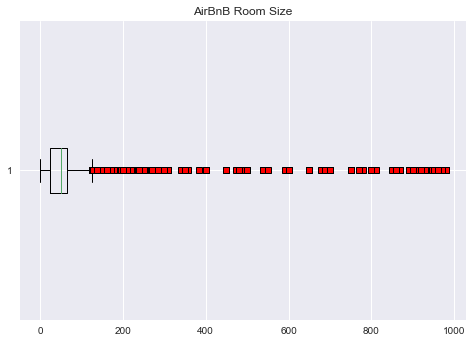

In [55]:
red_square = dict(markerfacecolor='r', marker='s')
fig1, ax1 = plt.subplots()
ax1.set_title('Horizontal Boxes')
ax1.boxplot(df['size'], vert=False, flierprops=red_square)
ax1.set_title('AirBnB Room Size')
plt.show()

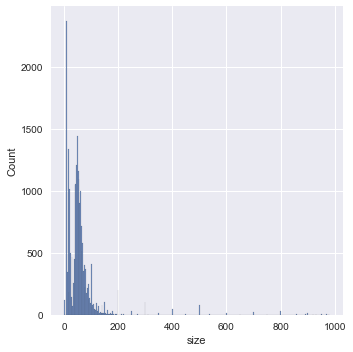

In [56]:
sns.displot(df['size'])

In [57]:
#delete size > $500 and size = $0
df.drop(df[ (df['size'] > 500) | (df['size'] == 0) ].index, axis=0, inplace=True)

In [58]:
df['size'].describe()

count    22139.000000
mean        55.413131
std         51.006910
min          1.000000
25%         25.000000
50%         49.692103
75%         64.924536
max        500.000000
Name: size, dtype: float64

In [59]:
from collections import Counter

In [60]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 21122),
 ('Kitchen', 20980),
 ('Heating', 20826),
 ('Essentials', 19972),
 ('Washer', 18208),
 ('Hair dryer', 14597),
 ('Laptop friendly workspace', 14216),
 ('Hangers', 13638),
 ('Iron', 10984),
 ('Shampoo', 10432),
 ('TV', 9883),
 ('Hot water', 9519),
 ('Family/kid friendly', 7988),
 ('Internet', 7761),
 ('Host greets you', 6537),
 ('Smoke detector', 6318),
 ('Buzzer/wireless intercom', 6002),
 ('Lock on bedroom door', 5188),
 ('Refrigerator', 5089),
 ('Free street parking', 5089),
 ('Dishes and silverware', 4964),
 ('Elevator', 4748),
 ('Cooking basics', 4726),
 ('Stove', 4703),
 ('Bed linens', 4700),
 ('Smoking allowed', 4541),
 ('Oven', 4208),
 ('translation missing: en.hosting_amenity_50', 4125),
 ('First aid kit', 3915),
 ('Cable TV', 3615)]

In [61]:
amenities_df = pd.DataFrame(results.most_common(30), columns=['amenities', 'count'])

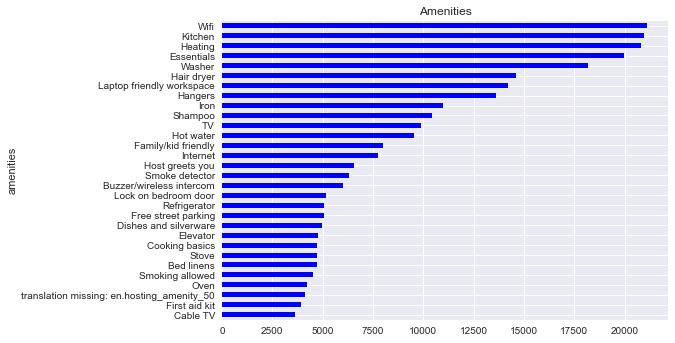

In [62]:
amenities_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenities', y='count',
                                                            legend = False, color = 'blue', title = 'Amenities')
plt.show()

In [63]:
df['TV'] = df['amenities'].str.contains('TV')
df['Wifi'] = df['amenities'].str.contains('Wifi')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [64]:
df.drop(['amenities'], axis=1, inplace=True)

# EDA

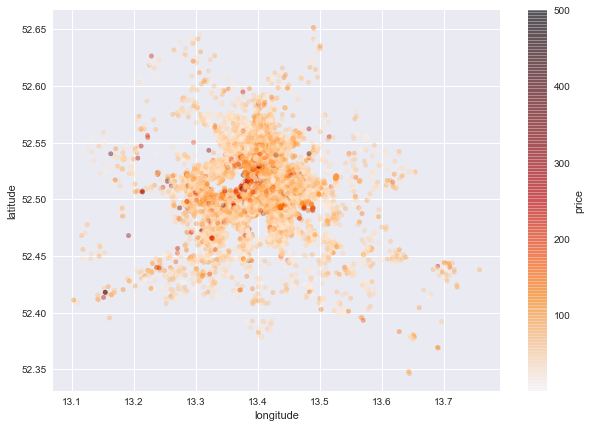

In [65]:
#Price difference on MAP

df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

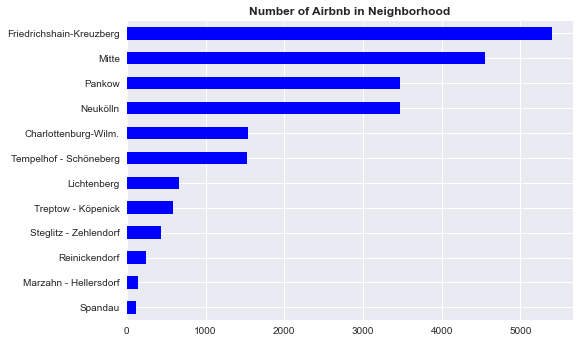

In [66]:
#No of Airbnb in each neighborhood
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='blue')
plt.title('Number of Airbnb in Neighborhood', fontweight='bold');

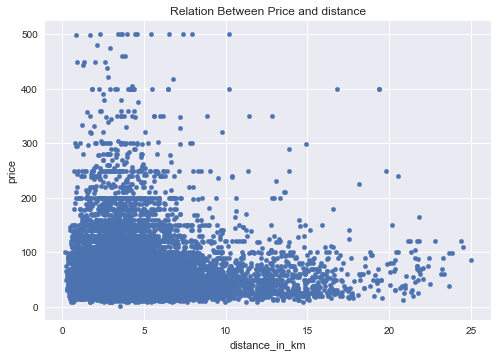

In [67]:
relation = df.plot.scatter('distance_in_km', 'price', title = 'Relation Between Price and distance')

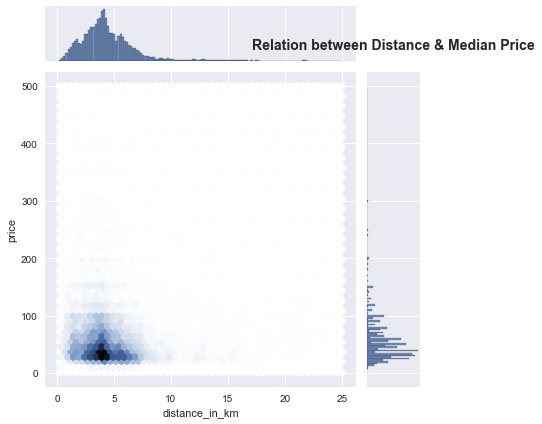

In [68]:
sns.jointplot(x=df["distance_in_km"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

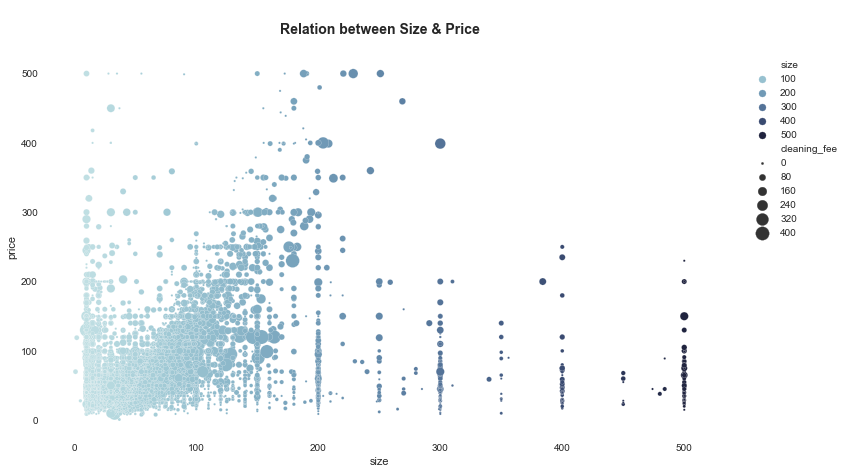

In [69]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

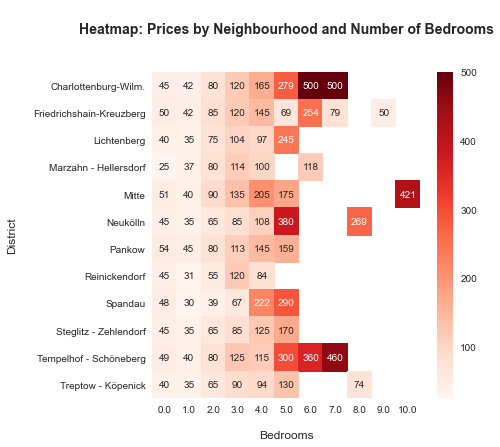

In [70]:
plt.figure(figsize=(6,6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

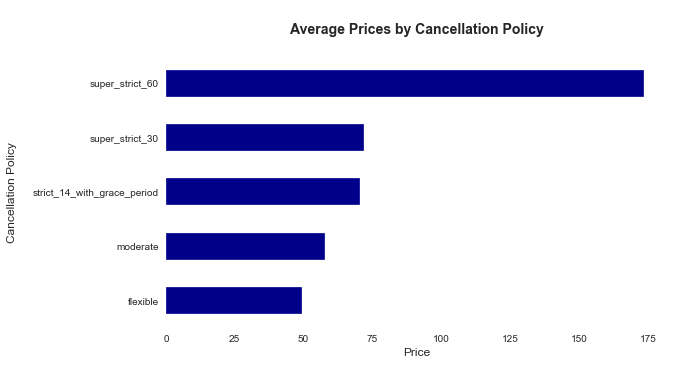

In [71]:
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.mean))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nAverage Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

In [72]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance_in_km',
       'size', 'description', 'host_has_profile_pic',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'bed_type', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'TV', 'Wifi', 'Smoking_allowed'],
      dtype='object')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22139 entries, 2015 to 29867352
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  22139 non-null  int64  
 1   bathrooms                     22139 non-null  float64
 2   bedrooms                      22139 non-null  float64
 3   price                         22139 non-null  float64
 4   cleaning_fee                  22139 non-null  float64
 5   security_deposit              22139 non-null  float64
 6   extra_people                  22139 non-null  float64
 7   guests_included               22139 non-null  int64  
 8   distance_in_km                22139 non-null  float64
 9   size                          22139 non-null  float64
 10  description                   21937 non-null  object 
 11  host_has_profile_pic          22139 non-null  object 
 12  neighbourhood_group_cleansed  22139 non-null  object 


In [74]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type', 'description'], axis=1, inplace=True)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22139 entries, 2015 to 29867352
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accommodates              22139 non-null  int64  
 1   bathrooms                 22139 non-null  float64
 2   bedrooms                  22139 non-null  float64
 3   price                     22139 non-null  float64
 4   cleaning_fee              22139 non-null  float64
 5   security_deposit          22139 non-null  float64
 6   extra_people              22139 non-null  float64
 7   guests_included           22139 non-null  int64  
 8   distance_in_km            22139 non-null  float64
 9   size                      22139 non-null  float64
 10  host_has_profile_pic      22139 non-null  object 
 11  room_type                 22139 non-null  object 
 12  bed_type                  22139 non-null  object 
 13  minimum_nights            22139 non-null  int64  
 14  

# Regression

In [76]:
# 1)

X = df.drop(['price',
             'host_has_profile_pic',
             'room_type',
             'bed_type',
             'instant_bookable',
             'is_business_travel_ready',
             'cancellation_policy',
             'TV',
             'Wifi',
             'Smoking_allowed'], axis=1) # input
y = df['price'] # output (dependent variable)

In [77]:
# 2) Splitting our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False, random_state=SEED)

In [78]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [79]:
# Import the linear regression algorithm
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

# Train the model
regressor.fit(X_train, y_train)

LinearRegression()

In [80]:
# Kept aside some data to test - X_test
y_pred = regressor.predict(X_test)

compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [81]:
compare_df

,Desired Output (Actuals),Predicted Output
23747623,20.0,25.288911
23748559,30.0,46.938829
23749216,55.0,27.086355
23749409,30.0,43.906545
23750840,50.0,60.074274
...,...,...
29856708,60.0,41.327183
29857108,20.0,76.016594
29864272,85.0,32.355755
29866805,99.0,43.729930


In [82]:
# The coefficients
print('Coefficients: \n', regressor.coef_)

# The mean squared error
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Coefficients: 
 [13.53791532  3.07493434  6.32252553  7.79885889  1.83117465 -0.42416653
  5.07124663 -3.62918189  5.48296261  0.04768222]
Mean squared error: 1698.28
Coefficient of determination: 0.29


In [83]:
# Evaluate the model's training score and test score
print("Regression model's training score = {:.2f}".format(regressor.score(X_train, y_train)))
print("Regression model's test score     = {:.2f}".format(regressor.score(X_test, y_test)))

Regression model's training score = 0.46
Regression model's test score     = 0.29


In [84]:
own_pred = regressor.predict(X_test)
print("My target value is   =", str(own_pred[0]))
print("My observed value is =", str(y_test.iloc[0]))

My target value is   = 25.288911152484022
My observed value is = 20.0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22139 entries, 2015 to 29867352
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accommodates              22139 non-null  int64  
 1   bathrooms                 22139 non-null  float64
 2   bedrooms                  22139 non-null  float64
 3   price                     22139 non-null  float64
 4   cleaning_fee              22139 non-null  float64
 5   security_deposit          22139 non-null  float64
 6   extra_people              22139 non-null  float64
 7   guests_included           22139 non-null  int64  
 8   distance_in_km            22139 non-null  float64
 9   size                      22139 non-null  float64
 10  host_has_profile_pic      22139 non-null  object 
 11  room_type                 22139 non-null  object 
 12  bed_type                  22139 non-null  object 
 13  minimum_nights            22139 non-null  int64  
 14  

In [86]:
# get importance
importance = regressor.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 13.53792
Feature: 1, Score: 3.07493
Feature: 2, Score: 6.32253
Feature: 3, Score: 7.79886
Feature: 4, Score: 1.83117
Feature: 5, Score: -0.42417
Feature: 6, Score: 5.07125
Feature: 7, Score: -3.62918
Feature: 8, Score: 5.48296
Feature: 9, Score: 0.04768


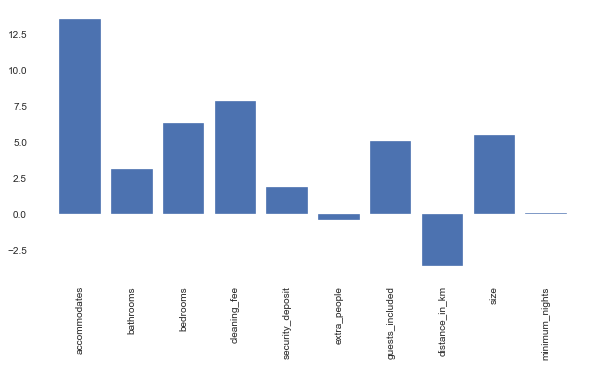

In [87]:
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
plt.figure(figsize=(10,5))
plt.bar([x for x in X], importance)
plt.xticks(rotation=90)
plt.show()

# Random Forest

In [88]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [89]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

In [90]:
#splitting, convert cat to numeric and combining.

#numeric
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()


#categorical
# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)


In [91]:
features_coded = pd.concat([num_feats, cat_feats], axis=1)

In [92]:
print(features_coded.shape)
pd.set_option('display.max_columns', None)
features_coded.head(2)

(22139, 31)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance_in_km,size,minimum_nights,TV,Wifi,Smoking_allowed,host_has_profile_pic_f,host_has_profile_pic_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,True,True,False,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,False,True,False,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0


In [93]:
features_coded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22139 entries, 2015 to 29867352
Data columns (total 31 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   accommodates                                     22139 non-null  int64  
 1   bathrooms                                        22139 non-null  float64
 2   bedrooms                                         22139 non-null  float64
 3   cleaning_fee                                     22139 non-null  float64
 4   security_deposit                                 22139 non-null  float64
 5   extra_people                                     22139 non-null  float64
 6   guests_included                                  22139 non-null  int64  
 7   distance_in_km                                   22139 non-null  float64
 8   size                                             22139 non-null  float64
 9   minimum_nights        

In [94]:
X = features_coded # input
y = target # output (dependent variable)

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X ,y, 
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    random_state=SEED)

In [96]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [97]:
# create a baseline
booster = xgb.XGBRegressor()

In [98]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [99]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

C:\Users\Sevester Retseves\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [100]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 26.4273


In [101]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6691


# K-Fold Cross Validation

In [102]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [103]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [104]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,69.274089,0.594044,69.329674,1.221218
1,66.478554,0.557571,66.602633,1.224647
2,63.868822,0.516301,64.065079,1.244883
3,61.338196,0.493155,61.601499,1.230489
4,59.017612,0.488449,59.336691,1.228252


In [105]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,18.309037,0.313115,26.351921,0.804948
196,18.290129,0.313411,26.348661,0.808763
197,18.267682,0.310879,26.343635,0.810443
198,18.256347,0.309944,26.341659,0.810109
199,18.237603,0.311393,26.336552,0.808793


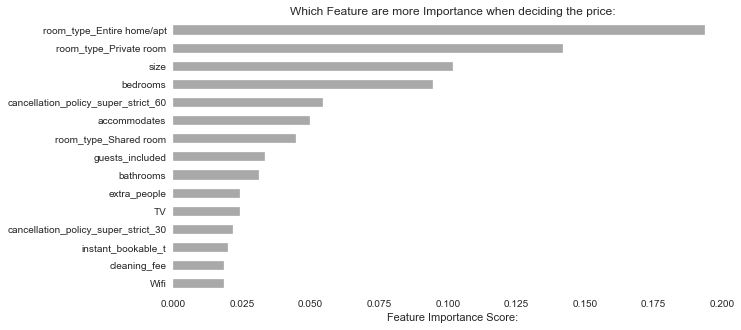

In [106]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_coded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Feature Importance Score:')
plt.title('Which Feature are more Importance when deciding the price:');

# Random Forest -> lesser features

In [107]:
X = features_coded # input
y = target # output (dependent variable)

In [108]:
pd.set_option('display.max_columns', None)
X

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance_in_km,size,minimum_nights,TV,Wifi,Smoking_allowed,host_has_profile_pic_f,host_has_profile_pic_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.000000,4,True,True,False,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.000000,2,False,True,False,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0
3176,4,1.0,1.0,50.0,200.0,20.0,2,3.695677,68.000000,62,False,True,False,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0
3309,2,1.0,1.0,30.0,250.0,18.0,1,3.755285,26.000000,5,False,True,False,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0
7071,2,1.0,1.0,0.0,0.0,24.0,1,4.550423,20.000000,2,False,True,False,0,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856708,2,1.0,1.0,0.0,0.0,0.0,1,3.464543,51.868431,2,False,True,True,0,1,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0
29857108,6,1.0,1.0,0.0,0.0,10.0,1,4.288544,54.000412,1,True,True,False,0,1,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0
29864272,2,1.0,0.0,0.0,0.0,0.0,1,3.270333,58.298232,3,False,True,False,0,1,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0
29866805,2,1.0,1.0,0.0,0.0,0.0,1,2.643811,63.179811,1,False,True,False,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0


In [109]:
pd.set_option('display.max_columns', None)
y

,price
2015,60.0
2695,17.0
3176,90.0
3309,26.0
7071,42.0
...,...
29856708,60.0
29857108,20.0
29864272,85.0
29866805,99.0


In [110]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
y = np.array(df['price'])
# Remove the labels from the features
# axis 1 refers to the columns
X = df.drop(['price',
             'host_has_profile_pic',
             'room_type',
             'bed_type',
             'instant_bookable',
             'is_business_travel_ready',
             'cancellation_policy',
             'TV',
             'Wifi',
             'Smoking_allowed'], axis = 1)
# Saving feature names for later use
X_list = list(X.columns)
# Convert to numpy array
X = np.array(X)

In [111]:
pd.set_option('display.max_columns', None)
X[0]

array([  3.      ,   1.      ,   1.      ,  30.      , 200.      ,
        28.      ,   1.      ,   3.533182,  75.      ,   4.      ])

In [112]:
pd.set_option('display.max_columns', None)
y[0]

60.0

In [113]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED)

In [114]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)


Training Features Shape: (17711, 10)
Training Labels Shape: (4428, 10)
Testing Features Shape: (17711,)
Testing Labels Shape: (4428,)


In [115]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = SEED)
# Train the model on training data
rf.fit(X, y);

In [116]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [117]:
y_pred = rf.predict(X_test)

compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [118]:
compare_df[:10]

,Desired Output (Actuals),Predicted Output
0,29.0,38.550
1,29.0,37.207
2,45.0,50.765
3,25.0,25.415
4,60.0,61.138
5,49.0,58.823
6,49.0,48.887
7,30.0,30.010
8,29.0,42.750
9,50.0,50.333


In [119]:
# The mean squared error
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))


Mean squared error: 106.04


In [120]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 4.92


In [121]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.94 %.


In [122]:
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.11010
Feature: 1, Score: 0.03137
Feature: 2, Score: 0.07317
Feature: 3, Score: 0.07050
Feature: 4, Score: 0.02756
Feature: 5, Score: 0.05583
Feature: 6, Score: 0.02783
Feature: 7, Score: 0.11243
Feature: 8, Score: 0.44544
Feature: 9, Score: 0.04577


<BarContainer object of 10 artists>

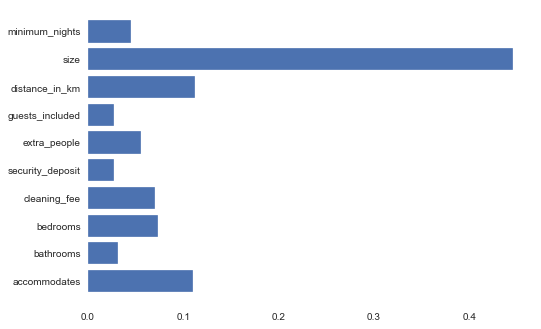

In [123]:
plt.barh(X_list, rf.feature_importances_)

In [124]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: size                 Importance: 0.45
Variable: accommodates         Importance: 0.11
Variable: distance_in_km       Importance: 0.11
Variable: bedrooms             Importance: 0.07
Variable: cleaning_fee         Importance: 0.07
Variable: extra_people         Importance: 0.06
Variable: minimum_nights       Importance: 0.05
Variable: bathrooms            Importance: 0.03
Variable: security_deposit     Importance: 0.03
Variable: guests_included      Importance: 0.03


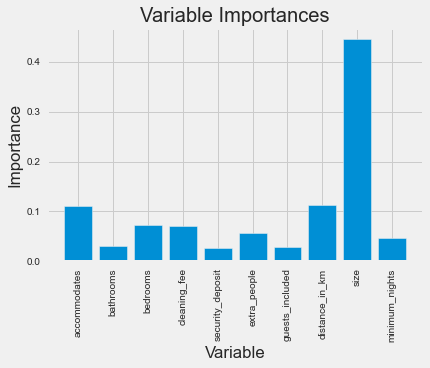

In [125]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, X_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Hyperparameter tuning RandomSearch with Cross Validation

In [126]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = SEED)
from pprint import pprint
# Look at parameters used by our current forest
rf = rf.fit(X_train, y_train)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [127]:
from sklearn.metrics import explained_variance_score
predictions = rf.predict(X_test)
score = explained_variance_score(y_test, predictions)
print(score)

0.6289981362441766


In [128]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [129]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [130]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [131]:
rf_random.best_score_

0.6241257650995122

In [132]:
# Use the forest's predict method on the test data
predictions = rf_random.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 13.92


In [133]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 73.81 %.


# Hyperparameter tuning GridSearch with Cross Validation

In [134]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': ['auto'],
    'min_samples_leaf': [0, 1, 2],
    'min_samples_split': [0, 1, 2],
    'n_estimators': [100, 200, 300, 400]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [135]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Sevester Retseves\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.61860474 0.6208453  0.61977733 0.62042444
        nan        nan        nan        nan        nan        nan
        nan        nan 0.62158015 0.62276965 0.62186677 0.62155146]
  warnings.warn(


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [136]:
grid_search.best_score_

0.6227696457949264

In [137]:
# Use the forest's predict method on the test data
predictions = grid_search.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 13.5


In [138]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.0 %.


In [139]:
R2 = r2_score(y_test, predictions)

In [140]:
R2

0.6309538437704949